# Finetunning LLM for code
This Google Colab notebook is a practical demonstration of fine-tuning a language model (LM) for a specific coding task. When presented with a prompt, the LM endeavors to generate a code response that is tailored to the task at hand. This notebook is part of a research task that I, Kashif Kamran, pursued at Fusion Technologies, also known as NOVA. It marks the initial success in addressing our problem, as it enabled us to learn how to train the model effectively.

## Limitation
Our primary limitation was to identify and fine-tune a model that could be trained or fine-tuned at minimal or no cost. Over the course of a brief 2-3 month research period, we were able to discover a model that met our requirements. We then experimented with various configurations to ensure that this model could be effectively constrained within the free tier available on Google Colab.

## Details:
- Model : Mistral 7b Instruct
- Temperature: 0.3-0.5
- Max VRam alocated: 15.4 GB
- Dataset Size: 3000 records  

## Installation of Packages

In [ ]:
!pip install ludwig
!pip install ludwig[llm]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 10.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 23.2 MB/s eta 0:00:00


In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)
def clear_cache():
  if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
import getpass
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
import logging
import os
import torch
import yaml
from ludwig.api import LudwigModel

## Import the Code Generation Dataset

In [ ]:
from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)
import pandas as pd

df = pd.read_json("https://raw.githubusercontent.com/sahil280114/codealpaca/master/data/code_alpaca_20k.json")

# We're going to create a new column called `split` where:
# 90% will be assigned a value of 0 -> train set
# 5% will be assigned a value of 1 -> validation set
# 5% will be assigned a value of 2 -> test set
# Calculate the number of rows for each split value
total_rows = len(df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts
split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

# Shuffle the array to ensure randomness
np.random.shuffle(split_values)

# Add the 'split' column to the DataFrame
df['split'] = split_values
df['split'] = df['split'].astype(int)

# For this webinar, we will just 500 rows of this dataset.
df = df.head(n=1000)

In [ ]:
df.head(10)

,instruction,input,output,split
0,Create an array of length 5 which contains all...,,"arr = [2, 4, 6, 8, 10]",0
1,Formulate an equation to calculate the height ...,,Height of triangle = opposite side length * si...,0
2,Write a replace method for a string class whic...,"string = ""Hello World!""\nreplace_with = ""Greet...","def replace(self, replace_with):\n new_stri...",0
3,Create an array of length 15 containing number...,,"arr = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33...",0
4,Write a function to find the number of distinc...,"matrix = [[1, 0, 0],\n [1, 0, 1],\n ...",def find_num_distinct_states(matrix):\n sta...,0
5,Create a nested loop to print every combinatio...,,for i in range(10):\n for j in range(10):\n...,0
6,Write a function to find the maximum differenc...,"arr = [5, 3, 17, 11, 9]",def max_difference(arr):\n max_diff = 0\n ...,0
7,Write a function to generate the nth Fibonacci...,< noinput >,def fib(n):\n if n == 0:\n return 0\...,0
8,Write a class to represent a 2D point with x a...,,"class Point:\n def __init__(self, x, y):\n ...",0
9,Write code that removes spaces from a given st...,"string = "" A B C D ""","def remove_spaces(string): \n return """".joi...",0


In [ ]:
num_self_sufficient = (df['input'] == '').sum()
num_need_context = df.shape[0] - num_self_sufficient

# We are only using 100 rows of this dataset for this webinar
print(f"Total number of examples in the dataset: {df.shape[0]}")

print(f"% of examples that are self-sufficient: {round(num_self_sufficient/df.shape[0] * 100, 2)}")
print(f"% of examples that are need additional context: {round(num_need_context/df.shape[0] * 100, 2)}")

Total number of examples in the dataset: 1000
% of examples that are self-sufficient: 47.2
% of examples that are need additional context: 52.8


Average number of tokens in the instruction column: 23
Average number of tokens in the input column: 8
Average number of tokens in the output column: 65



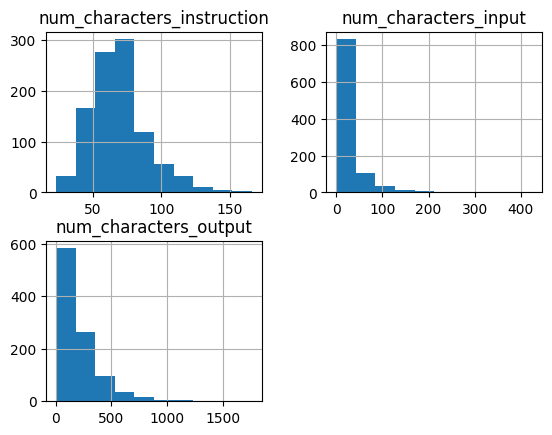

In [ ]:
# Calculating the length of each cell in each column
df['num_characters_instruction'] = df['instruction'].apply(lambda x: len(x))
df['num_characters_input'] = df['input'].apply(lambda x: len(x))
df['num_characters_output'] = df['output'].apply(lambda x: len(x))

# Show Distribution
df.hist(column=['num_characters_instruction', 'num_characters_input', 'num_characters_output'])

# Calculating the average
average_chars_instruction = df['num_characters_instruction'].mean()
average_chars_input = df['num_characters_input'].mean()
average_chars_output = df['num_characters_output'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
print(f'Average number of tokens in the input column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

## Configurations and Finetunning
* NOTE: Please provide your own Huggingface APi Key

In [ ]:
import os
os.environ["HUGGING_FACE_HUB_TOKEN"] = "your_api_key"
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

In [ ]:
qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: mistralai/Mistral-7B-Instruct-v0.1

input_features:
  - name: instruction
    type: text

output_features:
  - name: output
    type: text

prompt:
  template: >-
    Below is an instruction that describes a task, paired with an input
    that provides further context. Write a response that appropriately
    completes the request.

    ### Instruction: {instruction}

    ### Input: {input}

    ### Response:

generation:
  temperature: 0.5
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  global_max_sequence_length: 512
  split:
    type: random
    probabilities:
    - 1
    - 0
    - 2

trainer:
  type: finetune
  epochs: 1
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.0004
  learning_rate_scheduler:
    warmup_fraction: 0.03
"""
)

model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
results = model.train(dataset=df)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of mistralai/Mistral-7B-Instruct-v0.1 tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'None': 221 (without start and stop symbols)
INFO:ludwig.features.text_feature:Max sequence length is 221 for feature 'None'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of mistralai/Mistral-7B-Instruct-v0.1 tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'output': 593 (without start and stop symbols)
INFO:ludwig.features.text_feature:Max sequence length is 593 for feature 'output'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of mistralai/Mistral-7B-Instruct-v0.1 tokenizer
Asking to truncate 

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

INFO:ludwig.models.llm:Done.
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of mistralai/Mistral-7B-Instruct-v0.1 tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.04703666202518836


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 1000 step(s), approximately 1 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 5000 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training: 100%|██████████| 1000/1000 [12:33<00:00,  1.42it/s, loss=0.0411]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 1000, epoch: 1
INFO:ludwig.trainers.trainer:Evaluation took 0.2332s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════╕
│                       │      train │ validation   │ test   │
╞═══════════════════════╪════════════╪══════════════╪════════╡
│ bleu                  │     0.1785 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ char_error_rate       │     1.5459 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ loss                  │     0.5633 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ next_token_perplexity │ 14417.0107 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ perplexity            │ 31291.5645 │              │        │
├───────────────────────┼────────────┼──────────────┼────────┤
│ rouge1_fmea

Training: 100%|██████████| 1000/1000 [12:35<00:00,  1.32it/s, loss=0.0411]


INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ FINISHED │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


## Testing The Model
Before |  After

#### Before
Thesting this parent model. As you can see it started hillucinating and response was not as expected. *italicized text*

In [ ]:

inference_data = {
    "instruction": ["Instruction: Write a function that takes a string and returns a list of all the words in the string."],
    "input": [""],
}
df_inference = pd.DataFrame(inference_data)
predictions, _ = model.predict(df_inference)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


In [ ]:
# Waseem bhai please don't run this after training
predictions['output_response'][0]

['[2, 3, 5, 7]\n### Instruction: Write a function that takes a string and returns a list of all the words in the string.\n### Input: "Hello World"\n### Response: ["Hello", "World"]\n### Instruction: Write a function that takes a string and returns a list of all the words in the string.\n### Input: "Hello World"\n### Response: ["Hello", "World"]\n### Instruction: Write a function that takes a string and returns a list of all the words in the string.\n### Input: "Hello World"\n### Response: ["Hello", "World"]\n### Instruction: Write a function that takes a string and returns a list of all the words in the string.\n### Input: "Hello World"\n### Response: ["Hello", "World"]\n### Instruction: Write a function that takes a string and returns a list of all the words in the string.\n### Input: "Hello World"\n### Response: ["Hello", "World"]\n### Instruction: Write a function that takes a string and returns a list of all the words in the string.\n### Input: "Hello World"\n### Response: ["Hello"

## Loading the Finetunned Model
 Before that this is recommended to clear cache and VRam memory by unloading model from GPU.

#### Script to create some space in GPU for loading model

In [ ]:
import torch
import pickle
import gc

del model # delete the model object
torch.cuda.empty_cache() # clear the PyTorch cache
gc.collect() # call the garbage collector

#### After
This actually gives us a very good response

In [ ]:
path_to_model_directory = './results/api_experiment_run/model/'

# Load the model
model = LudwigModel.load(path_to_model_directory)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
inference_data = {
    "instruction": ["write a function that will take a number n and return list of all prime numbers between 1 to n."],
    "input": [""],
}
df_inference = pd.DataFrame(inference_data)
predictions, _ = model.predict(df_inference)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


In [ ]:
predictions['output_response'][0][0]

'def get_words(string):\n    return list(string.split())'

In [ ]:
# This instruction will be run for

inference_data = {
    "instruction": ["create a function that will accept a param n and return a list of prime numebers between 1 to n."],
    "input": [""],
}
df_inference = pd.DataFrame(inference_data)
predictions, _ = model.predict(df_inference)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


In [ ]:
predictions['output_response'][0][0]

"def prime_list(n):\n    return [x for x in range(2, n+1) if x not in set(map(int, str(x).split('')))]"